## Data Augmentation

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(12, 5)
import PIL

In [2]:
image_path = keras.utils.get_file('cat.jpg',
                                  'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')

24576/17858 [=========================================] - 0s 0us/step


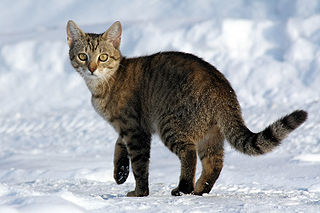

In [3]:
PIL.Image.open(image_path)

In [4]:
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels=3)

In [5]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1, 2, 1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### 이미지 뒤집기

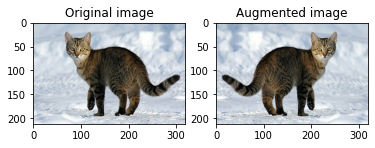

In [6]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### GrayScale로 변환

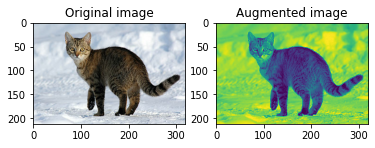

In [7]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))

### 이미지 채도 변경

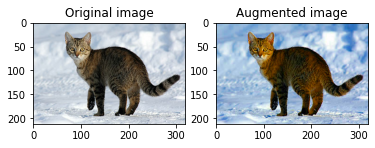

In [8]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

### 밝기 변경

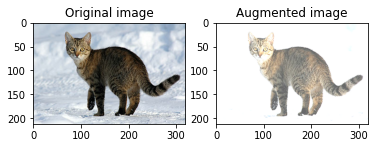

In [9]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

### 회전

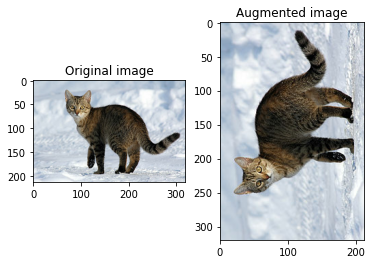

In [10]:
roatated = tf.image.rot90(image)
visualize(image, roatated)

### 중앙 편집

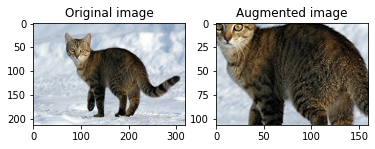

In [11]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

### 실제 학습에 활용

In [12]:
cifar10 = keras.datasets.cifar10

(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [13]:
train_data, test_data = train_data/255., test_data/255.

In [14]:
num_train_example = len(train_data)

In [15]:
num_train_example

50000

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

In [17]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

In [18]:
def augment(image, label):
  image, label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 38, 38)
  image = tf.image.random_crop(image, size=(32, 32, 3))
  image = tf.image.random_brightness(image, max_delta=0.5)
  return image, label

In [19]:
NUM_EXAMPLES = 2048
BATCH_SIZE = 64

In [20]:
augmented_train_batches = (
    train_dataset
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_example//4)
    .map(augment)
    .batch(BATCH_SIZE)
)

In [21]:
non_augmented_train_batches = (
    train_dataset
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_example//4)
    .map(convert)
    .batch(BATCH_SIZE)
)

In [22]:
validation_batches = (
    test_dataset
    .map(convert)
    .batch(BATCH_SIZE)
)

In [23]:
def make_model():
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model
  

In [30]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches,
                                       epochs=50,
                                       validation_data = validation_batches)

Epoch 1/50
32/32 [==============================] - 1s 27ms/step - loss: 4.4293 - accuracy: 0.1396 - val_loss: 2.1113 - val_accuracy: 0.1986
Epoch 2/50
32/32 [==============================] - 1s 28ms/step - loss: 2.0222 - accuracy: 0.2607 - val_loss: 1.9976 - val_accuracy: 0.2508
Epoch 3/50
32/32 [==============================] - 1s 26ms/step - loss: 1.9038 - accuracy: 0.3062 - val_loss: 1.8996 - val_accuracy: 0.3275
Epoch 4/50
32/32 [==============================] - 1s 28ms/step - loss: 1.8317 - accuracy: 0.3398 - val_loss: 1.9343 - val_accuracy: 0.3119
Epoch 5/50
32/32 [==============================] - 1s 28ms/step - loss: 1.7562 - accuracy: 0.3721 - val_loss: 1.8786 - val_accuracy: 0.3262
Epoch 6/50
32/32 [==============================] - 1s 28ms/step - loss: 1.7186 - accuracy: 0.3721 - val_loss: 1.9935 - val_accuracy: 0.3050
Epoch 7/50
32/32 [==============================] - 1s 27ms/step - loss: 1.7209 - accuracy: 0.3643 - val_loss: 1.9156 - val_accuracy: 0.3137
Epoch 8/50
32

In [31]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches,
                                 epochs=50,
                                 validation_data = validation_batches)

Epoch 1/50
32/32 [==============================] - 1s 29ms/step - loss: 5.7048 - accuracy: 0.1533 - val_loss: 2.2798 - val_accuracy: 0.1666
Epoch 2/50
32/32 [==============================] - 1s 30ms/step - loss: 2.3294 - accuracy: 0.2100 - val_loss: 2.0749 - val_accuracy: 0.2407
Epoch 3/50
32/32 [==============================] - 1s 30ms/step - loss: 2.1635 - accuracy: 0.2388 - val_loss: 2.1044 - val_accuracy: 0.2149
Epoch 4/50
32/32 [==============================] - 1s 30ms/step - loss: 2.0574 - accuracy: 0.2651 - val_loss: 2.0698 - val_accuracy: 0.2536
Epoch 5/50
32/32 [==============================] - 1s 30ms/step - loss: 2.0696 - accuracy: 0.2705 - val_loss: 1.9504 - val_accuracy: 0.2933
Epoch 6/50
32/32 [==============================] - 1s 30ms/step - loss: 1.9962 - accuracy: 0.2759 - val_loss: 1.9390 - val_accuracy: 0.2806
Epoch 7/50
32/32 [==============================] - 1s 30ms/step - loss: 1.9555 - accuracy: 0.2910 - val_loss: 1.9783 - val_accuracy: 0.2681
Epoch 8/50
32

In [27]:
!pip install -q git+https://github.com/tensorflow/docs

In [28]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

(0.3, 1.0)

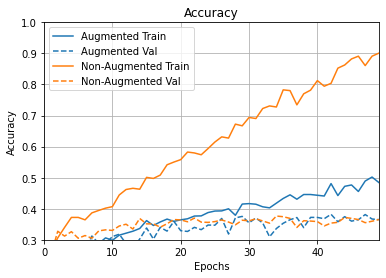

In [32]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot(
    {
      'Augmented': aug_history,
      'Non-Augmented': no_aug_history
    },
    metric='accuracy')
plt.title('Accuracy')
plt.ylim([0.3, 1])